In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path= '/content/drive/Shareddrives/캡스톤디자인/동서기공 RUL data/src_1129.json'
data_350 =  pd.read_json(path) 

In [22]:
c3 = data_350[data_350['completion']==3]

In [3]:
c3=c3.reset_index()

In [4]:
import numpy as np


In [6]:
c3['src_crop'][0]

array([192, 192, 193, ..., 197, 194, 196])

In [7]:
start= c3['src_crop'][0]

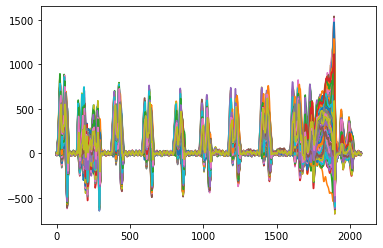

In [8]:
for i in range(len(c3)):

    plt.plot(c3['src_crop'][i]-start)

In [12]:
c1= data_350[data_350['completion']==1]
c2= data_350[data_350['completion']==2]

In [10]:
def differ(df):
    df=df.reset_index()
    for i in range(len(df)):
        df['src_crop'][i]= np.array(df['src_crop'][i])
    
    
    
    df['diff']=''
    start = df['src_crop'][0]
    for i in range(len(df)):
        df['diff'][i]= df['src_crop'][i] - start 

    df= df[1:]
    return df


In [13]:
c1= differ(c1)
c2 = differ(c2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [23]:
c3=differ(c3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


#모델 적용

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from tqdm.notebook import trange
#from TaPR_pkg import etapr
from pathlib import Path
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [80]:
def temporalize(X, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(X) - timesteps - 1):
        t = []
        for j in range(1, timesteps + 1):
            t.append(X[[(i + j + 1)], :])
        output_X.append(t)
        output_y.append(y[i + timesteps + 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

### train 넣는부분

In [81]:
src_temp = list()
for i in range(len(c3)):
  src_temp.append(c3["diff"].iloc[i])


In [82]:
train = np.array(src_temp)
x_train = train.reshape(train.shape[0], 1, train.shape[1])
x_train.shape

(349, 1, 2077)

In [83]:
def conv_auto_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]

    keras.backend.clear_session()

    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.Dense(128),
            layers.LSTM(
                units=64, activation="relu", name="lstm_1", return_sequences=False
            ),
            layers.Dense(64),
            layers.RepeatVector(n_steps),
            layers.Dense(64),
            layers.LSTM(
                units=64, activation="relu", name="lstm_2", return_sequences=True
            ),
            layers.Dense(128),
            layers.Conv1D(filters=512, kernel_size=64, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.TimeDistributed(layers.Dense(x.shape[2], activation='linear'))
        ]
    )
    return model

In [84]:
model = conv_auto_model(x_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 512)            68059648  
                                                                 
 dense (Dense)               (None, 1, 128)            65664     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 repeat_vector (RepeatVector  (None, 1, 64)            0         
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 1, 64)             4160      
                                                        

In [85]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

epochs = 3
batch = 64

# fit
history = model.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                     validation_split=0.2, callbacks=[early_stopping]).history

Epoch 1/3
5/5 [==============================] - 45s 7s/step - loss: 18987.7949 - val_loss: 23158.8223
Epoch 2/3
5/5 [==============================] - 35s 7s/step - loss: 8654.2051 - val_loss: 15093.7588
Epoch 3/3
5/5 [==============================] - 35s 7s/step - loss: 7960.7725 - val_loss: 13399.8447


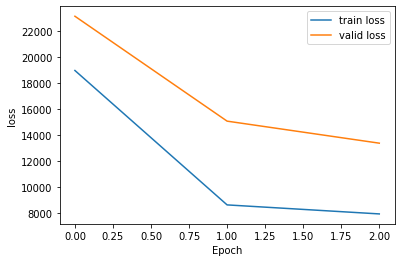

In [86]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [87]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [133]:
def validation(sample):
  sample["reconstruction error"] = 0
  
  src_temp = list()
  for i in range(len(sample)):
    src_temp.append(sample["diff"].iloc[i])

  val = np.array(src_temp)
  x_val = val.reshape(val.shape[0], 1, val.shape[1])

  start = time.time()
  valid_x_predictions = model.predict(x_val)
  print(valid_x_predictions.shape)

  #plt.plot(x_val[0][0])
  #plt.plot(valid_x_predictions[0][0])
  #plt.plot(valid_x_predictions[1][0])
  #plt.plot(valid_x_predictions[100][0])
  #plt.plot(valid_x_predictions[200][0])

  error = flatten(x_val) - flatten(valid_x_predictions)
  print(error.shape)

  valid_mse = np.mean(np.power(flatten(x_val) - flatten(valid_x_predictions), 2), axis=1)
  print(valid_mse.shape)
  print(time.time()-start)

  sample["reconstruction error"]=valid_mse
  plt.plot(valid_mse)
  #plt.ylim([100000,600000])


11/11 [==============================] - 1s 126ms/step
(342, 1, 2077)
(342, 2077)
(342,)
1.476745843887329


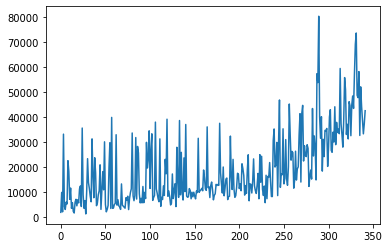

In [134]:
validation(c1)

11/11 [==============================] - 1s 132ms/step
(326, 1, 2077)
(326, 2077)
(326,)
2.638719320297241


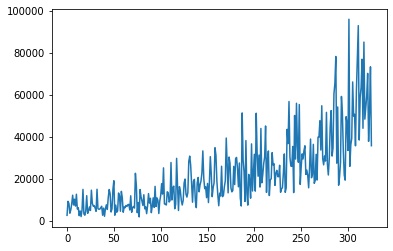

In [135]:
validation(c2)

11/11 [==============================] - 1s 129ms/step
(349, 1, 2077)
(349, 2077)
(349,)
1.5065662860870361


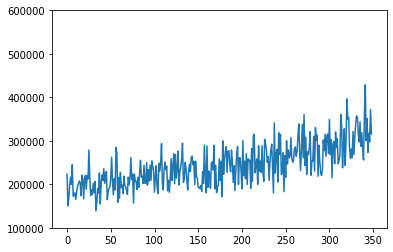

In [97]:
validation(c3)

In [98]:
from sklearn.preprocessing import  MinMaxScaler

In [99]:
scaler = MinMaxScaler()

In [ ]:
for i in range(len(c3)):
    maximum= max(c3['di'])

### 정규화하고 다시 train 시켜보기

In [24]:
c3['norm']=c3['diff']/1500

In [25]:
c1['norm']=c1['diff']/1500
c2['norm']=c2['diff']/1500




In [130]:
c3['norm'][1]

array([-0.00933333, -0.00933333, -0.01333333, ..., -0.00133333,
        0.002     ,  0.002     ])

In [26]:
src_temp = list()
for i in range(len(c3)):
  src_temp.append(c3["norm"].iloc[i])


In [27]:
train = np.array(src_temp)
x_train = train.reshape(train.shape[0], 1, train.shape[1])
x_train.shape

(348, 1, 2077)

In [73]:
def conv_auto_model(x):
    n_steps = x.shape[1]
    n_features = x.shape[2]

    keras.backend.clear_session()

    model = keras.Sequential(
        [
            layers.Input(shape=(n_steps, n_features)),
            layers.Conv1D(filters=128, kernel_size=32, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.Dense(64),
            layers.LSTM(
                units=32, activation="relu", name="lstm_1", return_sequences=False
            ),
            layers.Dense(32),
            layers.RepeatVector(n_steps),
            layers.Dense(32),
            layers.LSTM(
                units=32, activation="relu", name="lstm_2", return_sequences=True
            ),
            layers.Dense(64),
            layers.Conv1D(filters=128, kernel_size=32, padding='same', data_format='channels_last',
                          dilation_rate=1, activation="linear"),
            layers.TimeDistributed(layers.Dense(x.shape[2], activation='linear'))
        ]
    )
    return model

In [74]:
model = conv_auto_model(x_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 128)            8507520   
                                                                 
 dense (Dense)               (None, 1, 64)             8256      
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 repeat_vector (RepeatVector  (None, 1, 32)            0         
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 1, 32)             1056      
                                                        

In [75]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

epochs = 5
batch = 64

# fit
history = model.fit(x_train, x_train,
                     epochs=epochs, batch_size=batch,
                     validation_split=0.2, callbacks=[early_stopping]).history

Epoch 1/5
5/5 [==============================] - 9s 958ms/step - loss: 0.0092 - val_loss: 0.0199
Epoch 2/5
5/5 [==============================] - 4s 813ms/step - loss: 0.0087 - val_loss: 0.0188
Epoch 3/5
5/5 [==============================] - 4s 820ms/step - loss: 0.0080 - val_loss: 0.0168
Epoch 4/5
5/5 [==============================] - 4s 824ms/step - loss: 0.0064 - val_loss: 0.0083
Epoch 5/5
5/5 [==============================] - 4s 817ms/step - loss: 0.0040 - val_loss: 0.0065


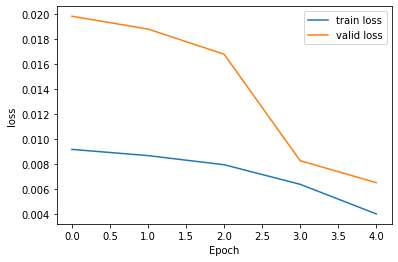

In [76]:
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

In [34]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [77]:
def validation(sample):
  sample["reconstruction error"] = 0
  
  src_temp = list()
  for i in range(len(sample)):
    src_temp.append(sample["norm"].iloc[i])

  val = np.array(src_temp)
  x_val = val.reshape(val.shape[0], 1, val.shape[1])

  start = time.time()
  valid_x_predictions = model.predict(x_val)
  print(valid_x_predictions.shape)

  #plt.plot(x_val[0][0])
  #plt.plot(valid_x_predictions[0][0])
  #plt.plot(valid_x_predictions[1][0])
  #plt.plot(valid_x_predictions[100][0])
  #plt.plot(valid_x_predictions[200][0])

  error = flatten(x_val) - flatten(valid_x_predictions)
  print(error.shape)

  valid_mse = np.mean(np.power(flatten(x_val) - flatten(valid_x_predictions), 2), axis=1)
  print(valid_mse.shape)
  print(time.time()-start)

  sample["reconstruction error"]=valid_mse
  plt.plot(valid_mse)
  #plt.ylim([100000,600000])


11/11 [==============================] - 1s 17ms/step
(342, 1, 2077)
(342, 2077)
(342,)
0.8809356689453125


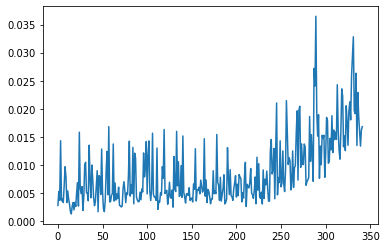

In [78]:
validation(c1)

11/11 [==============================] - 1s 120ms/step
(326, 1, 2077)
(326, 2077)
(326,)
2.620210647583008


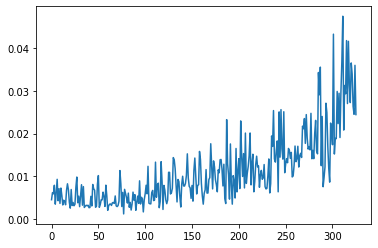

In [39]:
validation(c2)

11/11 [==============================] - 0s 17ms/step
(326, 1, 2077)
(326, 2077)
(326,)
0.2801685333251953


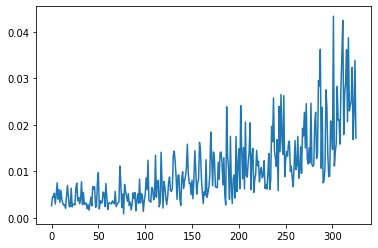

In [79]:
validation(c2)

In [40]:
c37 =data_350[data_350['completion']==37]

In [41]:
c37=differ(c37)
c37['norm']= c37['diff']/1500

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


11/11 [==============================] - 3s 207ms/step
(339, 1, 2077)
(339, 2077)
(339,)
2.665797233581543


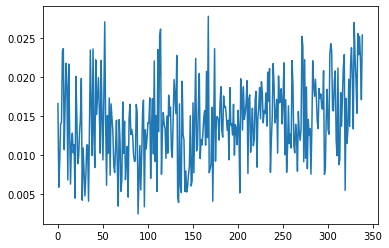

In [42]:
validation(c37)

In [46]:
c42['diff']

1      [1, -1, -3, -6, -4, -2, -1, 0, 1, 0, 2, 0, -7,...
2      [-7, -10, -15, -5, 18, 44, 70, 98, 127, 153, 1...
3      [-6, -8, -7, -7, -7, -5, -3, -4, -3, 0, 11, 20...
4      [14, 11, 7, 1, -3, -6, -10, -14, -10, -12, -16...
5      [-9, -11, -12, -14, -11, -8, -6, -3, -2, 5, 18...
                             ...                        
158    [10, 8, 3, -2, -3, -3, -5, -4, -6, -7, -1, 5, ...
159    [4, 1, 4, 4, 7, 10, 8, 5, 3, 2, -4, -15, -22, ...
160    [5, 3, -1, -3, 2, 3, 5, 4, 2, -1, 3, 12, 17, 2...
161    [-7, -9, -9, -9, -3, 0, 3, 14, 41, 77, 115, 13...
162    [11, 8, 3, -2, -7, -10, -15, -22, -25, -21, -4...
Name: diff, Length: 162, dtype: object

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


6/6 [==============================] - 1s 119ms/step
(162, 1, 2077)
(162, 2077)
(162,)
1.3428356647491455


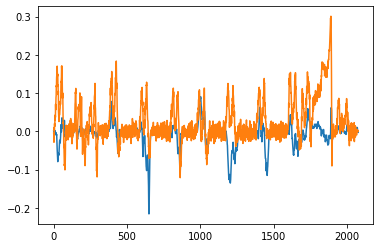

In [72]:
c42=data_350[data_350['completion']==42]
c42=differ(c42)
c42['norm']= c42['diff']/1500
validation(c42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


8/8 [==============================] - 1s 126ms/step
(243, 1, 2077)
(243, 2077)
(243,)
1.340453863143921


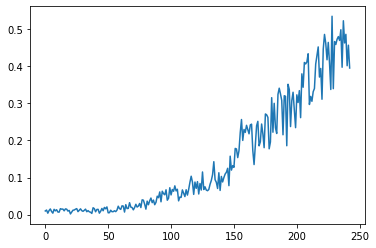

In [44]:
c74=data_350[data_350['completion']==74]
c74=differ(c74)
c74['norm']= c74['diff']/1500
validation(c74)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


4/4 [==============================] - 1s 197ms/step
(118, 1, 2077)
(118, 2077)
(118,)
1.0774919986724854


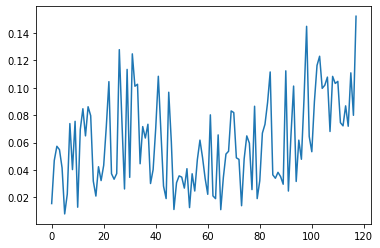

In [45]:
c89=data_350[data_350['completion']==89]
c89=differ(c89)
c89['norm']= c89['diff']/1500
validation(c89)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


11/11 [==============================] - 2s 132ms/step
(344, 1, 2077)
(344, 2077)
(344,)
2.686990261077881


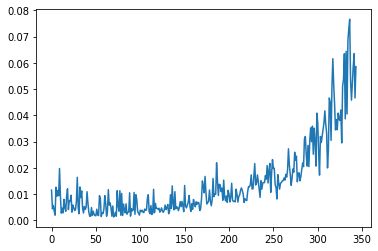

In [47]:
c6=data_350[data_350['completion']==6]
c6=differ(c6)
c6['norm']= c6['diff']/1500
validation(c6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


11/11 [==============================] - 2s 128ms/step
(345, 1, 2077)
(345, 2077)
(345,)
2.669957160949707


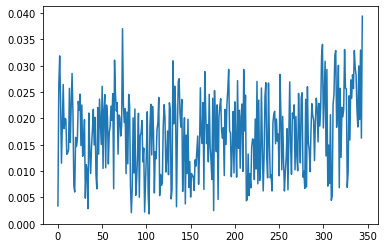

In [48]:
c12=data_350[data_350['completion']==12]
c12=differ(c12)
c12['norm']= c12['diff']/1500
validation(c12)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


11/11 [==============================] - 2s 154ms/step
(344, 1, 2077)
(344, 2077)
(344,)
1.9797253608703613


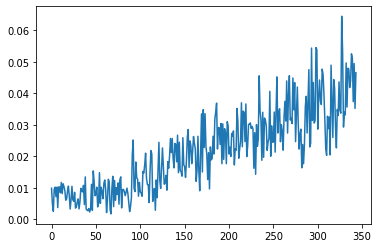

In [49]:
c22=data_350[data_350['completion']==22]
c22=differ(c22)
c22['norm']= c22['diff']/1500
validation(c22)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


11/11 [==============================] - 1s 123ms/step
(334, 1, 2077)
(334, 2077)
(334,)
1.4671037197113037


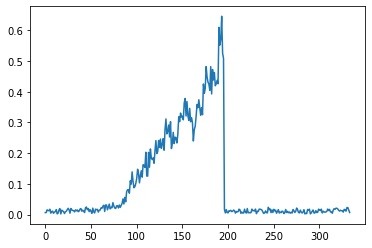

In [50]:
c85=data_350[data_350['completion']==85]
c85=differ(c85)
c85['norm']= c85['diff']/1500
validation(c85)

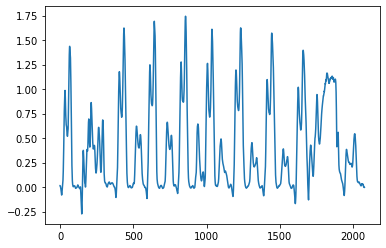

In [56]:
plt.plot(c85['norm'][150])

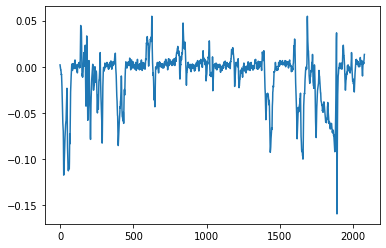

In [57]:
plt.plot(c85['norm'][200])

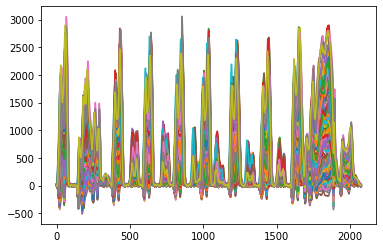

In [61]:
for i in range(1,180):
    plt.plot(c85['diff'][i])

KeyError: ignored

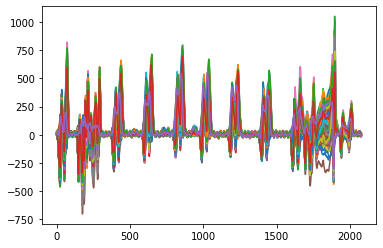

In [63]:
for i in range(200,350):
    plt.plot(c85['diff'][i])

,level_0,index,regDate,itemType,srcData,toolPreset,toolCount,start,end,len,path,completion,failure,RUL,src_crop,new_len,max_points,diff,norm,reconstruction error
1,24790,33920,1657832668000,normal_cycle,"[4653, 13464, 17884, 14031, 10309, 7504, 5413,...",350,3,16,2264,2248,8,85,350,347,"[180, 180, 179, 180, 181, 186, 197, 210, 224, ...",2085,"[1030, 1364, 920, 898, 881, 871, 790, 805, 889...","[-3, -5, -11, -16, -25, -31, -33, -35, -38, -4...","[-0.002, -0.0033333333333333335, -0.0073333333...",0.006340
2,24791,33921,1657833142000,normal_cycle,"[4642, 13456, 17897, 14058, 10332, 7518, 5418,...",350,4,12,2260,2248,8,85,350,346,"[193, 195, 197, 194, 190, 189, 189, 193, 200, ...",2085,"[979, 1395, 873, 772, 723, 706, 746, 790, 868,...","[10, 10, 7, -2, -16, -28, -41, -52, -62, -75, ...","[0.006666666666666667, 0.006666666666666667, 0...",0.006667
3,24792,33922,1657833622000,normal_cycle,"[1960, 10852, 17439, 15452, 11379, 8306, 6009,...",350,5,17,2265,2248,8,85,350,345,"[191, 195, 198, 202, 207, 207, 209, 209, 205, ...",2090,"[933, 1297, 849, 776, 784, 735, 756, 784, 825,...","[8, 10, 8, 6, 1, -10, -21, -36, -57, -81, -109...","[0.005333333333333333, 0.006666666666666667, 0...",0.015419
4,24793,33923,1657834101000,normal_cycle,"[4635, 13452, 17830, 13959, 10243, 7446, 5374,...",350,6,12,2260,2248,8,85,350,344,"[189, 190, 193, 195, 199, 202, 203, 203, 206, ...",2088,"[989, 1302, 772, 705, 710, 697, 669, 731, 905,...","[6, 5, 3, -1, -7, -15, -27, -42, -56, -74, -94...","[0.004, 0.0033333333333333335, 0.002, -0.00066...",0.013015
5,24794,33924,1657834655000,normal_cycle,"[1990, 10874, 17473, 15530, 11446, 8355, 6037,...",350,7,16,2265,2249,8,85,350,343,"[183, 183, 185, 187, 190, 191, 196, 198, 203, ...",2088,"[972, 1307, 789, 754, 755, 670, 627, 717, 844,...","[0, -2, -5, -9, -16, -26, -34, -47, -59, -75, ...","[0.0, -0.0013333333333333333, -0.0033333333333...",0.012573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,25119,34249,1658005014000,normal_cycle,"[3183, 12203, 17827, 14763, 10865, 7926, 5729,...",350,346,13,2261,2248,8,85,350,4,"[194, 195, 192, 190, 194, 202, 213, 227, 246, ...",2084,"[1287, 1469, 1197, 1253, 1279, 1173, 1139, 119...","[11, 10, 2, -6, -12, -15, -17, -18, -16, -26, ...","[0.007333333333333333, 0.006666666666666667, 0...",0.011033
331,25120,34250,1658005491000,normal_cycle,"[4630, 13448, 17823, 13960, 10253, 7469, 5391,...",350,347,15,2263,2248,8,85,350,3,"[206, 206, 206, 208, 210, 211, 208, 205, 201, ...",2090,"[1244, 1479, 1197, 1198, 1190, 1119, 1101, 110...","[23, 21, 16, 12, 4, -6, -22, -40, -61, -88, -1...","[0.015333333333333332, 0.014, 0.01066666666666...",0.022685
332,25121,34251,1658005959000,normal_cycle,"[6285, 14620, 17555, 13262, 9720, 7049, 5074, ...",350,348,13,2261,2248,8,85,350,2,"[199, 200, 204, 206, 207, 205, 203, 201, 194, ...",2090,"[1256, 1433, 1152, 1179, 1248, 1129, 1023, 108...","[16, 15, 14, 10, 1, -12, -27, -44, -68, -97, -...","[0.010666666666666666, 0.01, 0.009333333333333...",0.022846
333,25122,34252,1658006439000,normal_cycle,"[1018, 9416, 16729, 16266, 11993, 8770, 6342, ...",350,349,14,2263,2249,8,85,350,1,"[184, 184, 184, 183, 185, 191, 191, 195, 204, ...",2088,"[1197, 1451, 1144, 1173, 1192, 1058, 1061, 100...","[1, -1, -6, -13, -21, -26, -39, -50, -58, -64,...","[0.0006666666666666666, -0.0006666666666666666...",0.014566


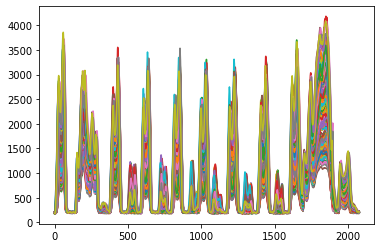

In [64]:
for i in range(1,180):
    plt.plot(c85['src_crop'][i])

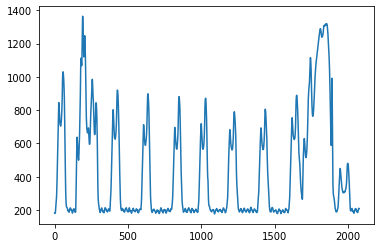

In [66]:
 plt.plot(c85['src_crop'][1])

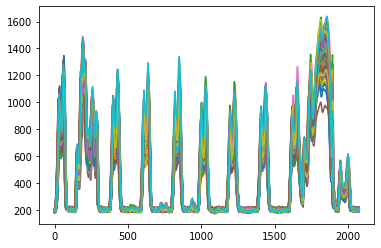

In [67]:
for i in range(200,330):
    plt.plot(c85['src_crop'][i])